In [1]:
from __future__ import print_function
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import pandas as pd
import pickle
from scipy.optimize import curve_fit
from scipy import stats

topdir = os.path.dirname(os.path.abspath("__file__"))
analysis_dir = os.path.join(topdir,"analysis_root_files")
data_pklname = os.path.join(analysis_dir,"tempScanSiDetRun1.pkl")
SPE_pklname = os.path.join(analysis_dir,"tempScanSiDetRun1SPE.pkl")

with open(data_pklname, 'rb') as f:
    df = pickle.load(f)
df = df.query("VoverN > 2.0").reset_index()

with open(SPE_pklname, 'rb') as f:
    df_SPE_clean = pickle.load(f)
    df_54V_Temp = pickle.load(f)
    df_55V_Temp = pickle.load(f)
    df_Vbd = pickle.load(f)

runs = df['run'].unique()
runs = np.sort(runs)
FEBs = df['FEB'].unique()
FEBs = np.sort(FEBs)
tempSetups = df['tempSetup'].unique()
tempSetups = np.sort(tempSetups)

bad_channels = [18, 29, 37, 38, 44, 58]

def func_lin(x, k, b):
    return k*x+b

def func_quad(x, a, b, c):
    return a*x*x+b*x+c

def func_cubic(x, a, b, c, d):
    return a*x*x*x+b*x*x+c*x+d
    

In [2]:
# Get overvoltage of each run
Vover = []
df_scan = df
for index, row in df_scan.iterrows():
    if row['ch'] in bad_channels:
        Vover.append(0)
    else:
        tChan = row['ch']

        df_Vbd_ = df_Vbd.query("chan == %i"%tChan).reset_index()
        VbdPerC = df_Vbd_['slope'][0]/1000.
        VbdIntercept = df_Vbd_['intercept'][0]
        tTemp = row['CMBtemp']
        tVppN = row['VppN']
        Vover.append(tVppN - (VbdPerC*tTemp+VbdIntercept))
        '''
        tVppN = row['VppN']
        tVbd = df_SPE_clean.query("chan == %i & temp_setup == %f"%(tChan,row['tempSetup'])).reset_index()['Vbd'][0]
        Vover.append(tVppN - tVbd)
        '''
        tRun = row['run']
# print(Vover)
df_scan.loc[:, 'Vover'] = np.array(Vover)

with pd.option_context('display.max_rows', 10,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    display(df_scan)

index   run  subrun  FEB  ch  pedestal  calibRaw  calibAdj   FEBtemp  \
0       128  1435       0    0   0   -11.184   307.683   352.443  45.88222   
1       129  1435       0    0   1    17.389   318.423   362.578  45.88222   
2       130  1435       0    0   2     1.862   324.581   368.518  45.88222   
3       131  1435       0    0   3    -1.296   315.535   359.811  45.88222   
4       132  1435       0    0   4   -11.689   312.258   356.008  45.88222   
...     ...   ...     ...  ...  ..       ...       ...       ...       ...   
5627   7035  1595       0    0  59    -7.160   769.569   571.517    45.492   
5628   7036  1595       0    0  60    -8.643   763.041   565.849    45.492   
5629   7037  1595       0    0  61    -4.633   791.272   593.620    45.492   
5630   7038  1595       0    0  62     2.163   771.695   574.330    45.492   
5631   7039  1595       0    0  63     8.477   752.641   554.852    45.492   

      CMBtemp   biasV     PEs  PEsCorrected  VoverN  VppN  tempSetup  \
0      25.500  53.776  31.867        33.956     2.5  54.0       25.0   
1      25.500  53.776  32.257        34.436     2.5  54.0       25.0   
2      25.500  53.776  47.699        50.959     2.5  54.0       25.0   
3      25.500  53.776  41.438        44.227     2.5  54.0       25.0   
4      25.493  53.776  27.566        29.456     2.5  54.0       25.0   
...       ...     ...     ...           ...     ...   ...        ...   
5627   -8.975  55.534  55.825        40.767     6.0  55.6      -10.0   
5628   -9.038  55.534  37.645        27.435     6.0  55.6      -10.0   
5629   -9.038  55.534  41.168        29.983     6.0  55.6      -10.0   
5630   -9.038  55.534  43.016        31.343     6.0  55.6      -10.0   
5631   -9.038  55.534  45.964        33.510     6.0  55.6      -10.0   

      tempSensor  Vover  
0           25.0  2.550  
1           25.0  2.559  
2           25.0  2.612  
3           25.0  2.565  
4           25.0  2.605  
...          ...    ...  
5627        -9.4  6.054  
5628        -9.4  6.066  
5629        -9.4  6.126  
5630        -9.4  6.026  
5631        -9.4  6.033  

[5632 rows x 18 columns]

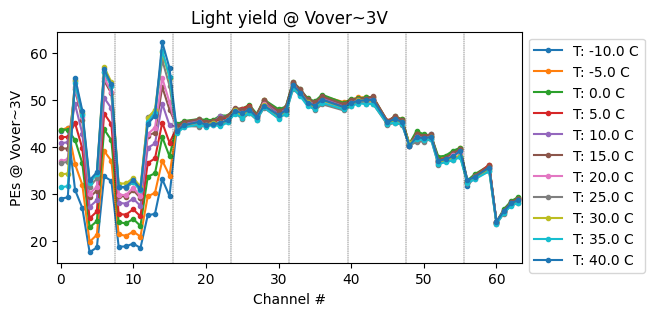

In [3]:
plt.figure(figsize = (6,3))
for temp in tempSetups:
    df_ = df_scan.query('tempSetup==%f & VoverN==3'%temp)
    mask = np.array([True if (ch not in bad_channels) else False for ch in df_['ch']])
    plt.plot(df_['ch'][mask], df_['PEs'][mask],'.-',
                 label='T: %.1f C'%temp)
plt.title("Light yield @ Vover~3V")
plt.xlabel("Channel #")
plt.ylabel("PEs @ Vover~3V")
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
for iAFE in range(8):
    plt.axvline(x=8*iAFE-0.5, color='k', linestyle='-'if iAFE==0 else '--', linewidth=0.3)
plt.gca().set_xlim(-0.5, 63+0.5)
plt.show()

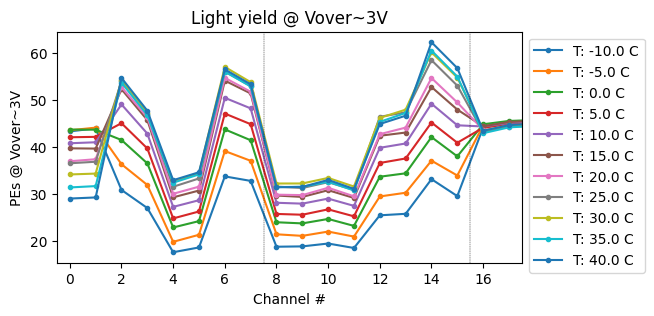

In [4]:
plt.figure(figsize = (6,3))
for temp in tempSetups:
    df_ = df_scan.query('tempSetup==%f & VoverN==3'%temp)
    mask = np.array([True if (ch not in bad_channels) else False for ch in df_['ch']])
    plt.plot(df_['ch'][mask], df_['PEs'][mask],'.-',
                 label='T: %.1f C'%temp)
plt.title("Light yield @ Vover~3V")
plt.xlabel("Channel #")
plt.ylabel("PEs @ Vover~3V")
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
for iAFE in range(8):
    plt.axvline(x=8*iAFE-0.5, color='k', linestyle='-'if iAFE==0 else '--', linewidth=0.3)
plt.gca().set_xlim(-0.5, 17+0.5)
plt.show()

0PE channel: 38 at set temp -10 C
0PE channel: 38 at set temp -5 C
0PE channel: 58 at set temp 5 C


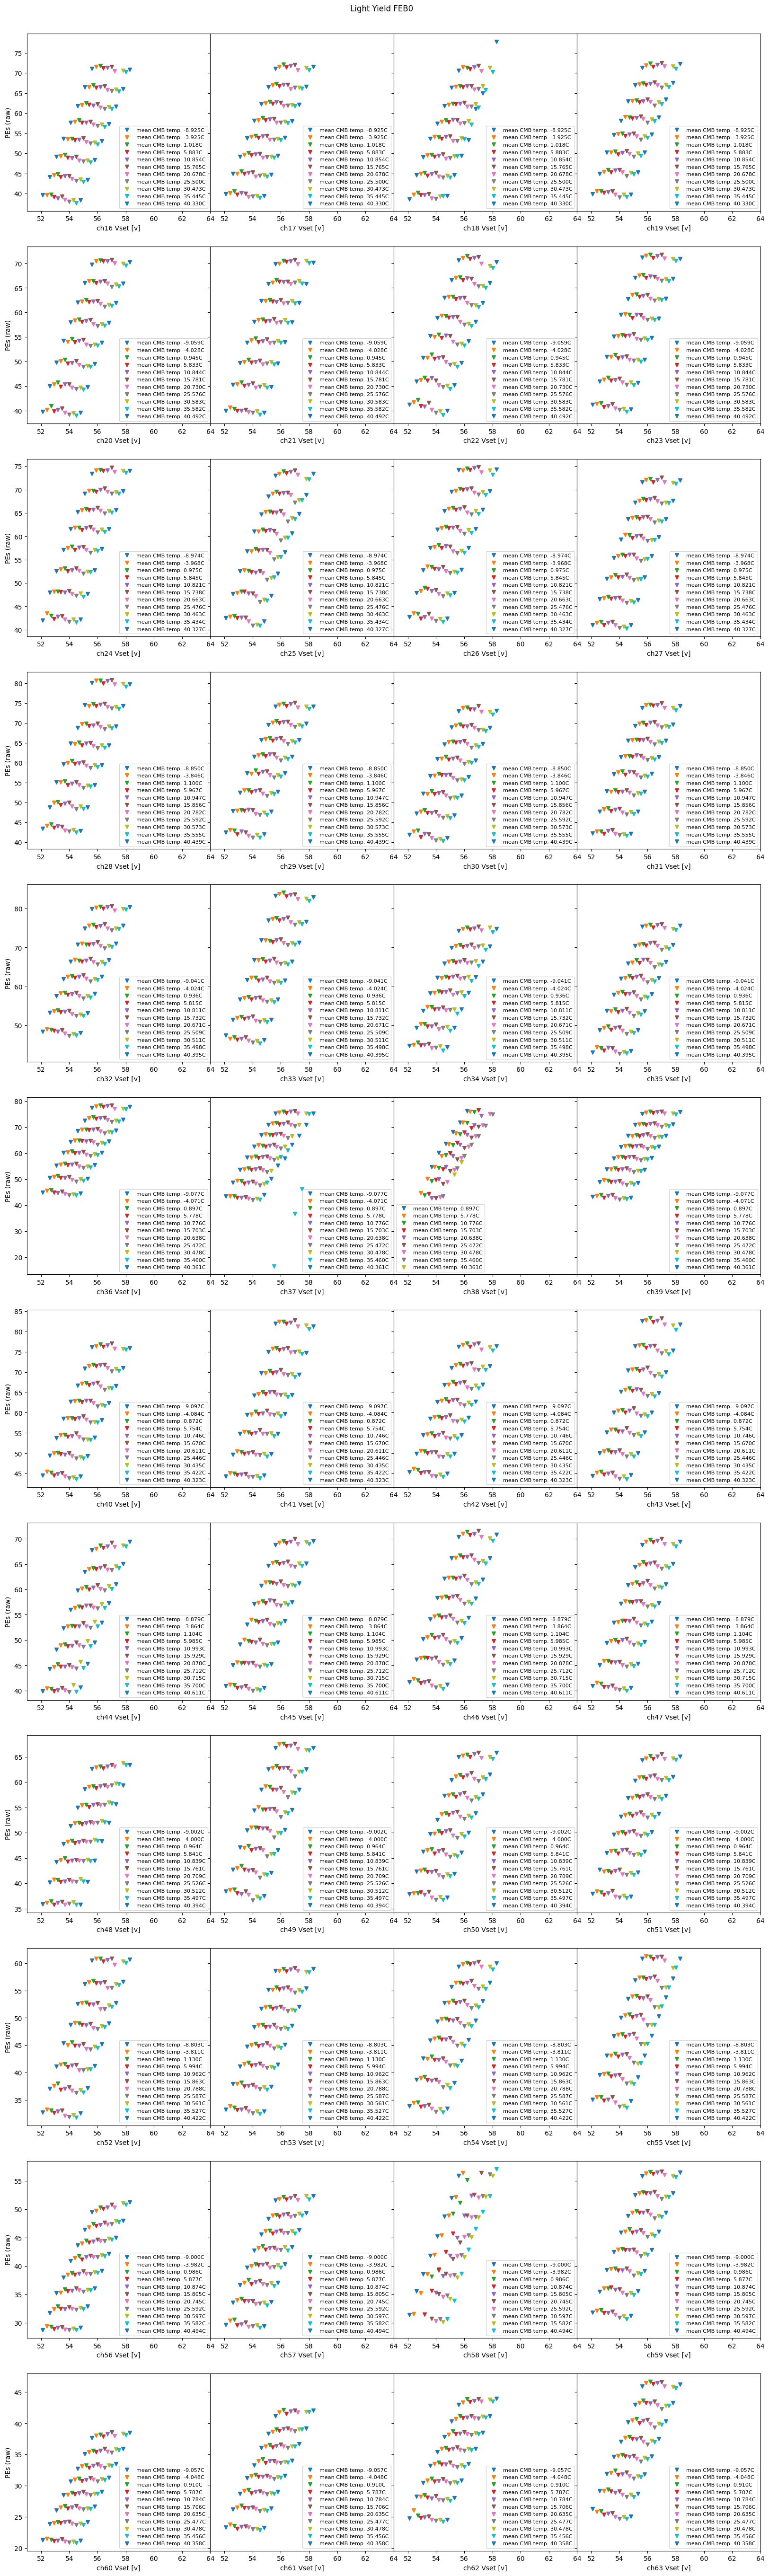

In [5]:
nr = 12
nc = 4

# grid of raw light yield
maintitle = 'Light Yield'
fig, axs = plt.subplots(nrows = nr, ncols = nc, figsize = (5*nc, 5*nr/0.97), sharey = 'row')
plt.suptitle(maintitle+" FEB0")
plt.subplots_adjust(wspace=0)
fig.subplots_adjust(top=0.97)
ytitle = 'PEs (raw)'
xtitle = 'Vset [v]'
for index, ax in enumerate(axs.flatten()):
    chan = index + 16
    ax.set_xlabel('ch%i '%chan+xtitle)
    if (index%4 == 0):
        ax.set_ylabel(ytitle)
    # if chan in bad_channels:
        # continue
    emptyFlag = True
    for tTempSetup in tempSetups:
        df_ = df_scan.query("ch==%i & tempSetup==%f"%(chan, tTempSetup)).reset_index()
        xx = df_['VppN'].astype(float)
        yy = df_['PEs'].astype(float)
            
        meanTemp = np.mean(df_['CMBtemp'].astype(float))
        mask = (yy>0)
        xx=xx[mask]
        yy=yy[mask]
        if yy.size==0:
            print("0PE channel: %d at set temp %.0f C"%(chan, tTempSetup))
            continue
        if True: #xx.size>3:
            emptyFlag = False
            #tscatter = ax.plot(xx, yy, 'v', label='Set temp. %.0fC, mean CMB temp. %.3fC'%(tTempSetup, meanTemp))
            tscatter = ax.plot(xx, yy, 'v', label='mean CMB temp. %.3fC'%(meanTemp))
            ax.set_xlim(51.,64.)
            # axs.set_ylim(20.,80.)
    if not emptyFlag:
        ax.legend(fontsize=8)
plt.show()

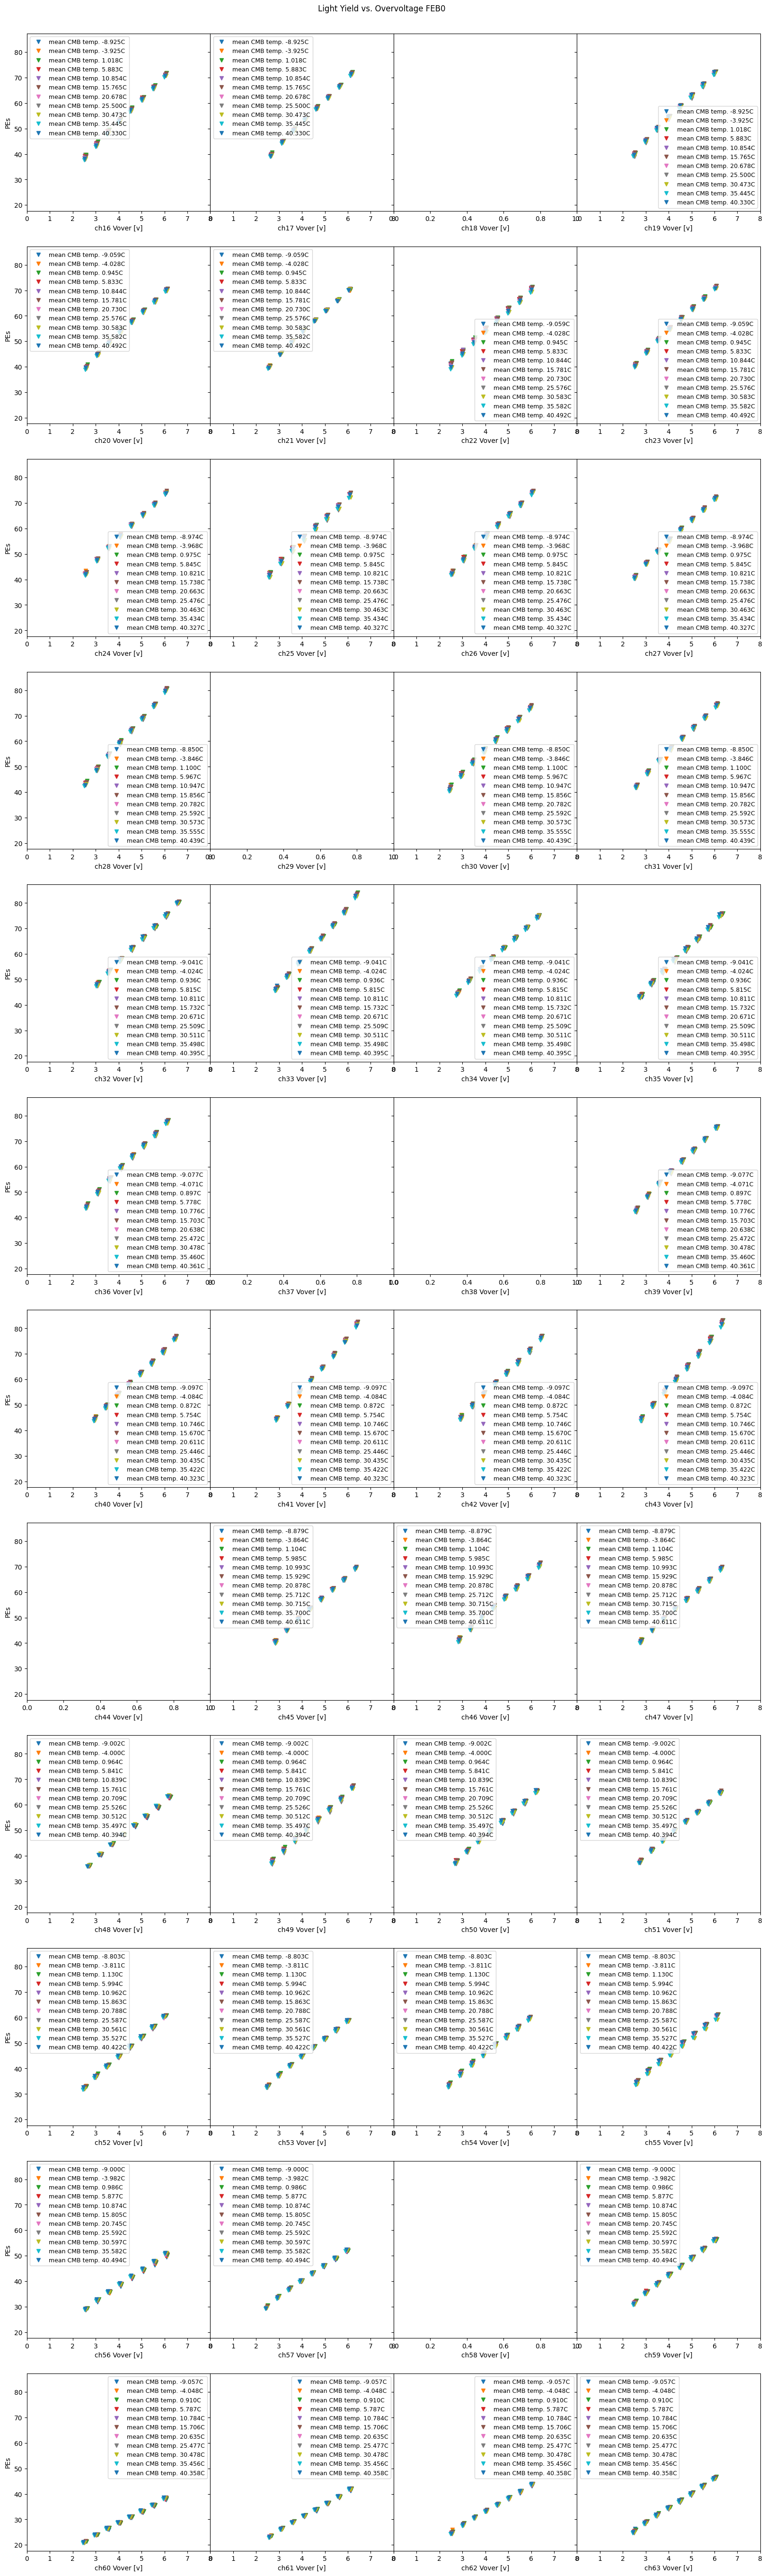

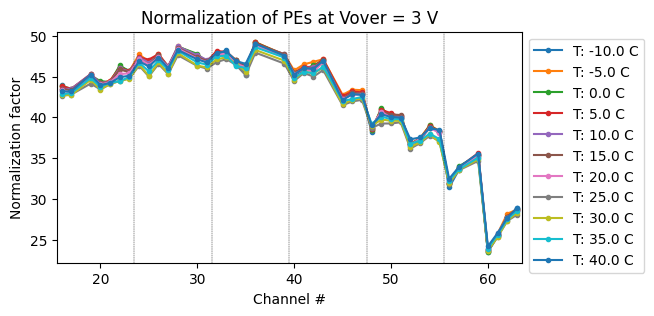

In [6]:
# grid of PEs vs Vover
normalization_Vover = 3
df_normalizationAt3VVover = pd.DataFrame(columns=['ch', 'tempSetup', 'normalization'])

maintitle = 'Light Yield vs. Overvoltage'
fig, axs = plt.subplots(nrows = nr, ncols = nc, figsize = (5*nc, 5*nr/0.97), sharey = True)
plt.suptitle(maintitle+" FEB0")
plt.subplots_adjust(wspace=0)
fig.subplots_adjust(top=0.97)
ytitle = 'PEs'
xtitle = 'Vover [v]'
for index, ax in enumerate(axs.flatten()):
    chan = index + 16
    ax.set_xlabel('ch%i '%chan+xtitle)
    if (index%4 == 0):
        ax.set_ylabel(ytitle)
    if chan in bad_channels:
        continue
    emptyFlag = True
    for tTempSetup in tempSetups:
        df_ = df_scan.query("ch==%i & tempSetup==%f"%(chan, tTempSetup)).reset_index()
        xx = df_['Vover'].astype(float)
        yy = df_['PEs'].astype(float)
        meanTemp = np.mean(df_['CMBtemp'].astype(float))
        mask = (yy>0)
        xx=xx[mask]
        yy=yy[mask]
        if yy.size==0:
            print("0PE channel: %d at set temp %.0f C"%(chan, tTempSetup))
            continue
        if True: #xx.size>3:
            emptyFlag = False
            tscatter = ax.plot(xx, yy, 'v', label='mean CMB temp. %.3fC'%(meanTemp))
            ax.set_xlim(0.,8.)
            # axs.set_ylim(20.,80.)
        if xx.size>3 and np.min(xx)<=3.5 and np.max(xx)>=2.5:
            popt, pcov = curve_fit(func_quad, xx.astype(float), yy.astype(float))
            #tNormalization = popt[0]*normalization_Vover*normalization_Vover*normalization_Vover + popt[1]*normalization_Vover*normalization_Vover + popt[2]*normalization_Vover + popt[3]
            tNormalization = popt[0]*normalization_Vover*normalization_Vover + popt[1]*normalization_Vover + popt[2]
            #tNormalization = popt[0]*normalization_Vover + popt[1]
            new_row = {'ch':chan, 
                       'tempSetup':tTempSetup, 
                       'normalization':tNormalization}
            df_normalizationAt3VVover.loc[len(df_normalizationAt3VVover)] = new_row            
        else:
            print("Cannot interpolate channel %d at set temp %.0f C"%(chan, tTempSetup))
            print(list(xx))
            new_row = {'ch':chan, 
                       'tempSetup':tTempSetup, 
                       'normalization':0.0}
            df_normalizationAt3VVover.loc[len(df_normalizationAt3VVover)] = new_row      
    if not emptyFlag:
        ax.legend(fontsize=9)
plt.show()

plt.figure(figsize = (6,3))
for temp in tempSetups:
    df_ = df_normalizationAt3VVover.query('tempSetup==%f & normalization>0'%temp)
    plt.plot(df_['ch'], df_['normalization'],'.-',
                 label='T: %.1f C'%temp)
plt.title("Normalization of PEs at Vover = 3 V")
plt.xlabel("Channel #")
plt.ylabel("Normalization factor")
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
for iAFE in range(2, 8):
    plt.axvline(x=8*iAFE-0.5, color='k', linestyle='-'if iAFE==0 else '--', linewidth=0.3)
plt.gca().set_xlim(15.5, 63+0.5)
plt.show()

This is closely related to Vbd. Errors in Vbd shift things. As some of the channels were not having perfect electric contact, some small error in Vbd not a surprise. ~2% level spread in such channels not a big surprise.  

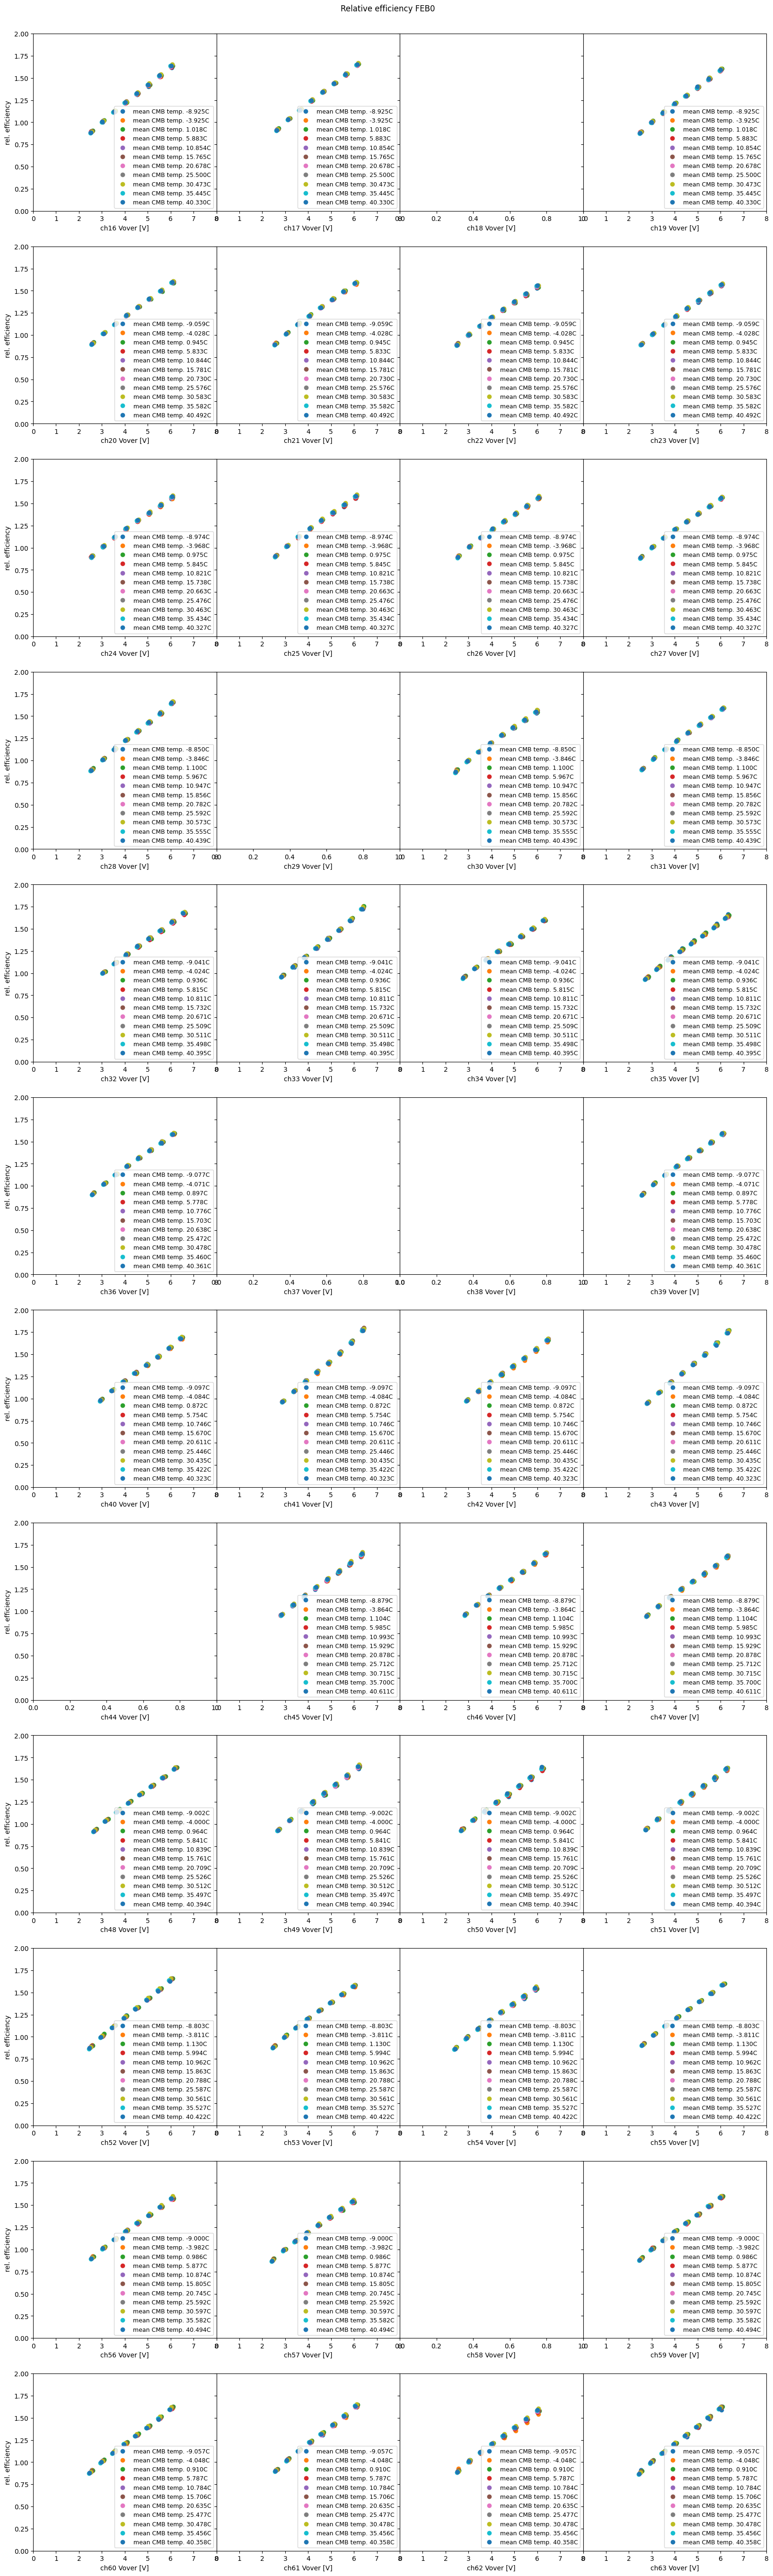

In [7]:
# grid normalized to 1 at 3 V overvoltage
all_x = np.array([])
all_y = np.array([])
maintitle = 'Relative efficiency'
fig, axs = plt.subplots(nrows = nr, ncols = nc, figsize = (5*nc, 5*nr/0.97), sharey = True)
plt.suptitle(maintitle+" FEB0")
plt.subplots_adjust(wspace=0)
fig.subplots_adjust(top=0.97)
ytitle = 'rel. efficiency'
xtitle = 'Vover [V]'
for index, ax in enumerate(axs.flatten()):
    chan = index + 16
    ax.set_xlabel('ch%i '%chan+xtitle)
    if (index%4 == 0):
        ax.set_ylabel(ytitle)
    if chan in bad_channels:
        continue
    emptyFlag = True
    for tTempSetup in tempSetups:
        df_ = df_scan.query("ch==%i & tempSetup==%f"%(chan, tTempSetup)).reset_index(drop=True)
        xx = df_['Vover'].astype(float)
        yy = df_['PEs'].astype(float)
        meanTemp = np.mean(df_['CMBtemp'].astype(float))
        mask = (yy>0)
        xx=xx[mask]
        yy=yy[mask]
        df_norm_ = df_normalizationAt3VVover.query("ch==%i & tempSetup==%f"%(chan, tTempSetup)).reset_index(drop=True)
        tNormalization = df_norm_['normalization'].astype(float)[0]
        if yy.size==0:
            print("0PE channel: %d at set temp %.0f C"%(chan, tTempSetup))
            continue
        if tNormalization == 0:
            print("Bad normalization channel: %d at set temp %.0f C"%(chan, tTempSetup))
            continue
        if True: #xx.size>3
            emptyFlag = False
            tscatter = ax.plot(xx, yy/tNormalization, 'o', label='mean CMB temp. %.3fC'%(meanTemp))
            ax.set_xlim(0.,8.)
            ax.set_ylim(0.,2.)
            all_x = np.append(all_x, xx)
            all_y = np.append(all_y, yy/tNormalization)
    if not emptyFlag:
        ax.legend(fontsize=9)
plt.show()

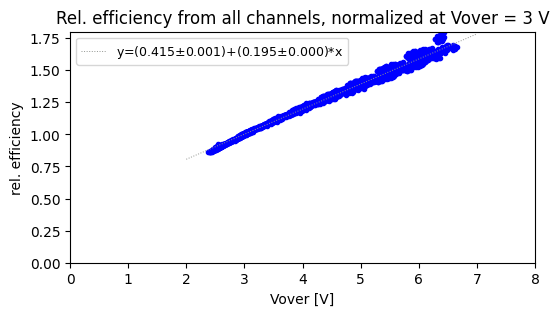

In [8]:
# relative efficiency vs. Vover are so similar across channels that they can be fit together
popt, pcov = curve_fit(func_lin, all_x, all_y)
slope = popt[0]
intercept = popt[1]
std_err = np.sqrt(pcov[0,0])
intercept_stderr = np.sqrt(pcov[1,1])
plt.figure(figsize = (6,3))
plt.plot(all_x, all_y, '.', color = 'b')
plt.plot(np.array([0.5*x for x in range(4, 15)]), slope * np.array([0.5*x for x in range(4, 15)]) + intercept, ':', color = '#929591', linewidth=0.7, 
         label='y=(%.3f$\pm$%.3f)+(%.3f$\pm$%.3f)*x'%(intercept, intercept_stderr, slope, std_err))
plt.title("Rel. efficiency from all channels, normalized at Vover = 3 V")
plt.legend(fontsize=9)
plt.xlabel('Vover [V]')
plt.ylabel('rel. efficiency')
plt.gca().set_xlim(0., 8.)
plt.gca().set_ylim(0., 1.8)
plt.show()

This converts to 21.6%/V at 2.5V overvoltage. This is consistent with run 2 analysis (20.9%/V), ~1% coming from uncertainties.

Looking back at the -1.27%/C (at 54V Vset) value in the first analysis, which comes from fixed Vset changeing temp. As SiPM Vbd has a changing rate of 55.4mV/C (or for fixed Vset, Vover has changing rate of -55.4mV/C), this becomes 22.9%/V at 2.5V Vover.

Throughout the 50 degC scan the LED changed from 17 degC to 27 degC, which is a decrease of 15% light yield. Expected contribution being -0.3%/C (5.4%/V). It seems the LED temperature contribution is way lower even in the first scan, as the new analysis method is completely independent of LED light yield.

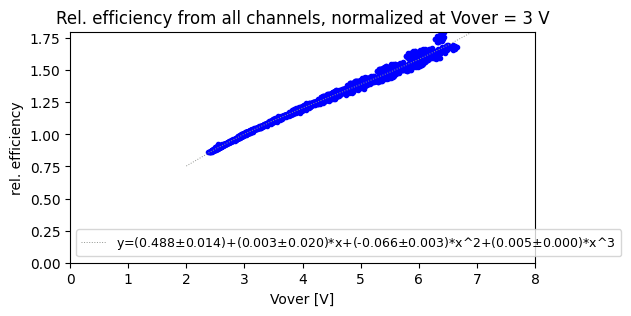

In [9]:
# relative efficiency vs. Vover are so similar across channels that they can be fit together
popt, pcov = curve_fit(func_cubic, all_x, all_y)
a = popt[0]
b = popt[1]
c = popt[2]
d = popt[3]
a_err = np.sqrt(pcov[0,0])
b_err = np.sqrt(pcov[1,1])
c_err = np.sqrt(pcov[2,2])
d_err = np.sqrt(pcov[3,3])
def tfunc(x):
    return a*x*x*x+b*x*x+c*x+d
plt.figure(figsize = (6,3))
plt.plot(all_x, all_y, '.', color = 'b')
dotx = np.array([0.5*x for x in range(4, 15)])
plt.plot(dotx, 
         np.apply_along_axis(tfunc, 0, dotx), ':', color = '#929591', linewidth=0.7, 
         label='y=(%.3f$\pm$%.3f)+(%.3f$\pm$%.3f)*x+(%.3f$\pm$%.3f)*x^2+(%.3f$\pm$%.3f)*x^3'%(c, c_err, d, d_err, b, b_err, a, a_err))
plt.title("Rel. efficiency from all channels, normalized at Vover = 3 V")
plt.legend(fontsize=9)
plt.xlabel('Vover [V]')
plt.ylabel('rel. efficiency')
plt.gca().set_xlim(0., 8.)
plt.gca().set_ylim(0., 1.8)
plt.show()

Compared to the results from the second SiDet run, the results seem very similar.  

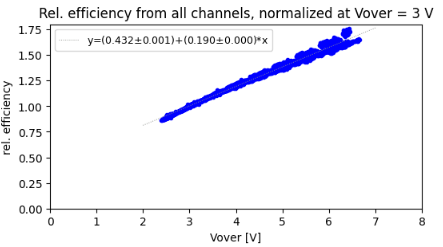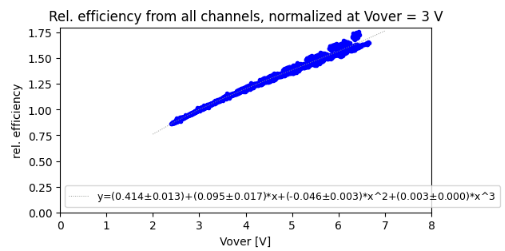

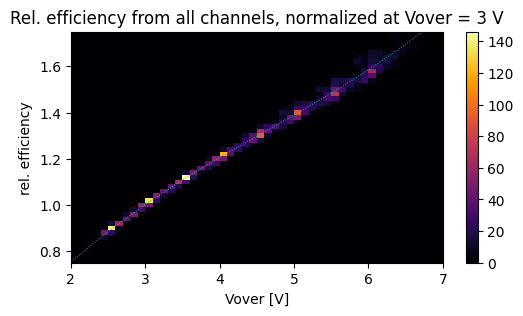

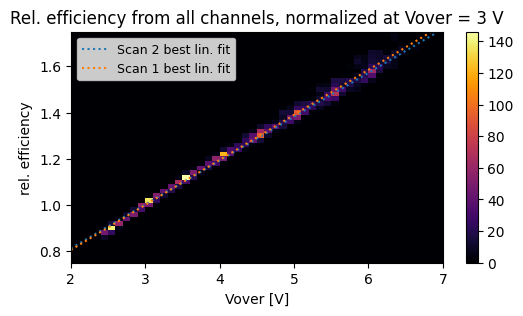

In [10]:
nx = 50 # 2-7V
xwidth = (7.-2.)/50.
ny = 50 # 0.75-1.75
ywidth = (1.75-0.75)/50.

fig, ax = plt.subplots(figsize = (6,3))
hist = ax.hist2d(all_x, all_y, bins = [[xwidth*i+2.0 for i in range(nx+1)], [ywidth*i+0.75for i in range(ny+1)]], cmap='inferno')
ax.plot(dotx, 
        np.apply_along_axis(tfunc, 0, dotx), ':', color = 'c', linewidth=0.7, 
        label='y=(%.3f$\pm$%.3f)+(%.3f$\pm$%.3f)*x+(%.3f$\pm$%.3f)*x^2+(%.3f$\pm$%.3f)*x^3'%(c, c_err, d, d_err, b, b_err, a, a_err))
plt.colorbar(hist[3], ax=ax, location='right')
plt.title("Rel. efficiency from all channels, normalized at Vover = 3 V")
plt.xlabel('Vover [V]')
plt.ylabel('rel. efficiency')
plt.gca().set_xlim(2., 7.)
plt.gca().set_ylim(0.75, 1.75)
plt.show()

fig, ax = plt.subplots(figsize = (6,3))
hist = ax.hist2d(all_x, all_y, bins = [[xwidth*i+2.0 for i in range(nx+1)], [ywidth*i+0.75for i in range(ny+1)]], cmap='inferno')
ax.plot(dotx, dotx*0.190+0.432, ':',label='Scan 2 best lin. fit')
ax.plot(dotx, dotx*0.195+0.415, ':',label='Scan 1 best lin. fit')
plt.colorbar(hist[3], ax=ax, location='right')
plt.title("Rel. efficiency from all channels, normalized at Vover = 3 V")
plt.xlabel('Vover [V]')
plt.ylabel('rel. efficiency')
plt.gca().set_xlim(2., 7.)
plt.gca().set_ylim(0.75, 1.75)
plt.legend(fontsize=9)
plt.show()

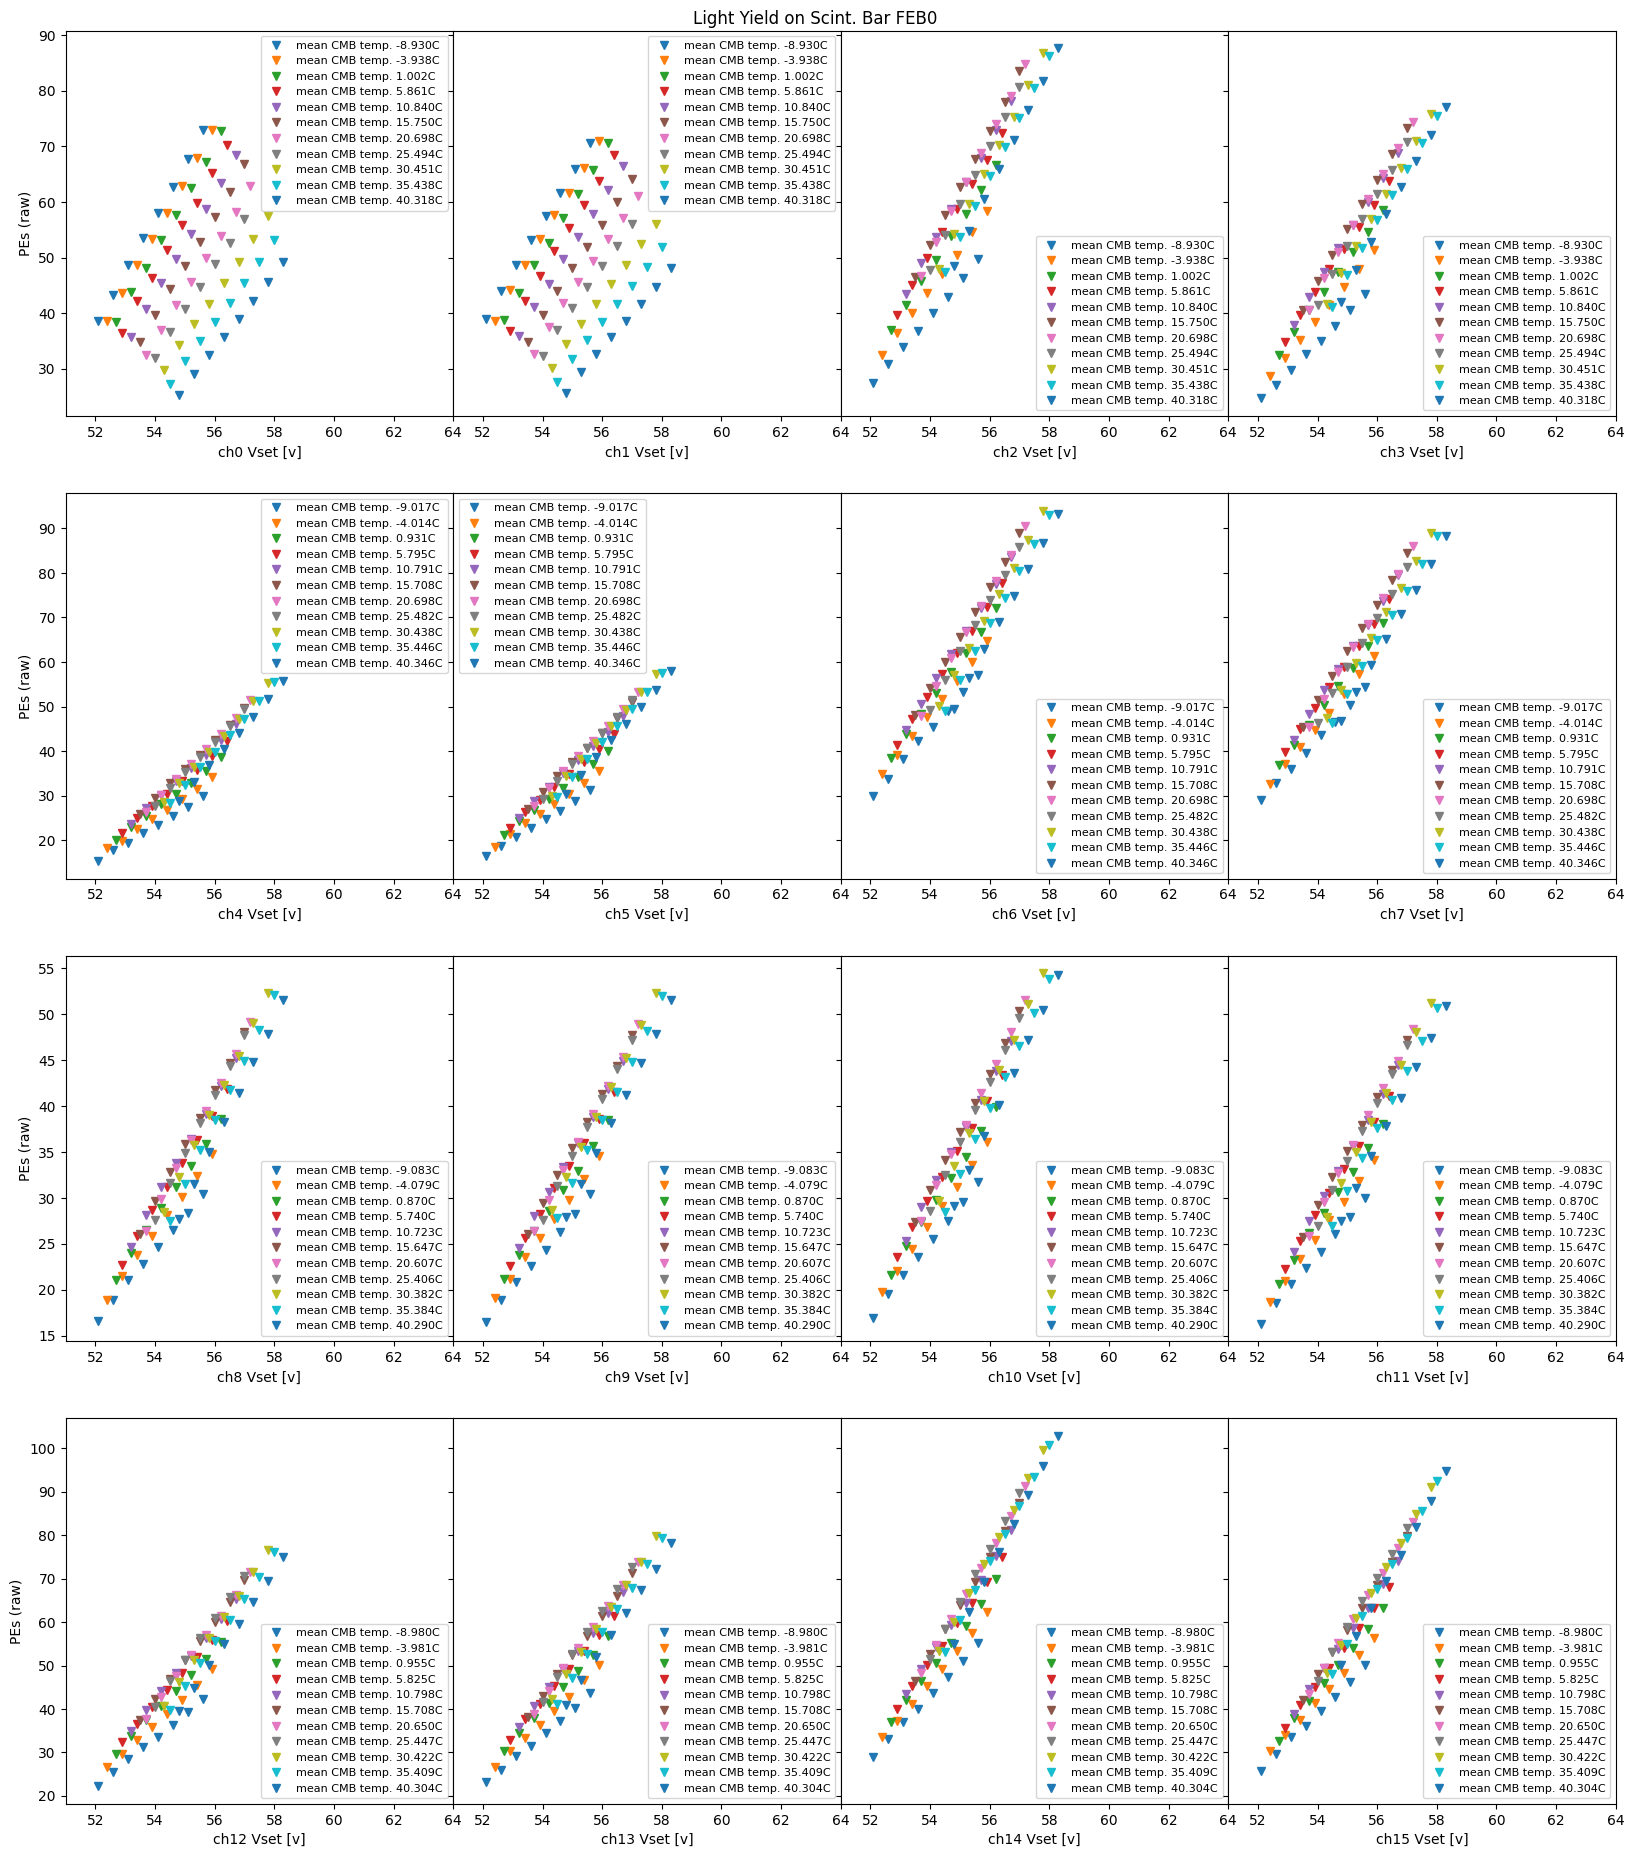

In [11]:
# Channel 0-15 have both SiPM effects and LED effects (+maybe light transmission of plastic). Interesting to see if can isolate LED effects.
nr = 4
nc = 4

# grid of raw light yield
maintitle = 'Light Yield on Scint. Bar'
fig, axs = plt.subplots(nrows = nr, ncols = nc, figsize = (5*nc, 5*nr/0.97), sharey = 'row')
plt.suptitle(maintitle+" FEB0")
plt.subplots_adjust(wspace=0)
fig.subplots_adjust(top=0.97)
ytitle = 'PEs (raw)'
xtitle = 'Vset [v]'
for index, ax in enumerate(axs.flatten()):
    chan = index
    ax.set_xlabel('ch%i '%chan+xtitle)
    if (index%4 == 0):
        ax.set_ylabel(ytitle)
    # if chan in bad_channels:
        # continue
    emptyFlag = True
    for tTempSetup in tempSetups:
        df_ = df_scan.query("ch==%i & tempSetup==%f"%(chan, tTempSetup)).reset_index()
        xx = df_['VppN'].astype(float)
        yy = df_['PEs'].astype(float)
            
        meanTemp = np.mean(df_['CMBtemp'].astype(float))
        mask = (yy>0)
        xx=xx[mask]
        yy=yy[mask]
        if yy.size==0:
            print("0PE channel: %d at set temp %.0f C"%(chan, tTempSetup))
            continue
        if True: #xx.size>3:
            emptyFlag = False
            #tscatter = ax.plot(xx, yy, 'v', label='Set temp. %.0fC, mean CMB temp. %.3fC'%(tTempSetup, meanTemp))
            tscatter = ax.plot(xx, yy, 'v', label='mean CMB temp. %.3fC'%(meanTemp))
            ax.set_xlim(51.,64.)
            # axs.set_ylim(20.,80.)
    if not emptyFlag:
        ax.legend(fontsize=8)
plt.show()

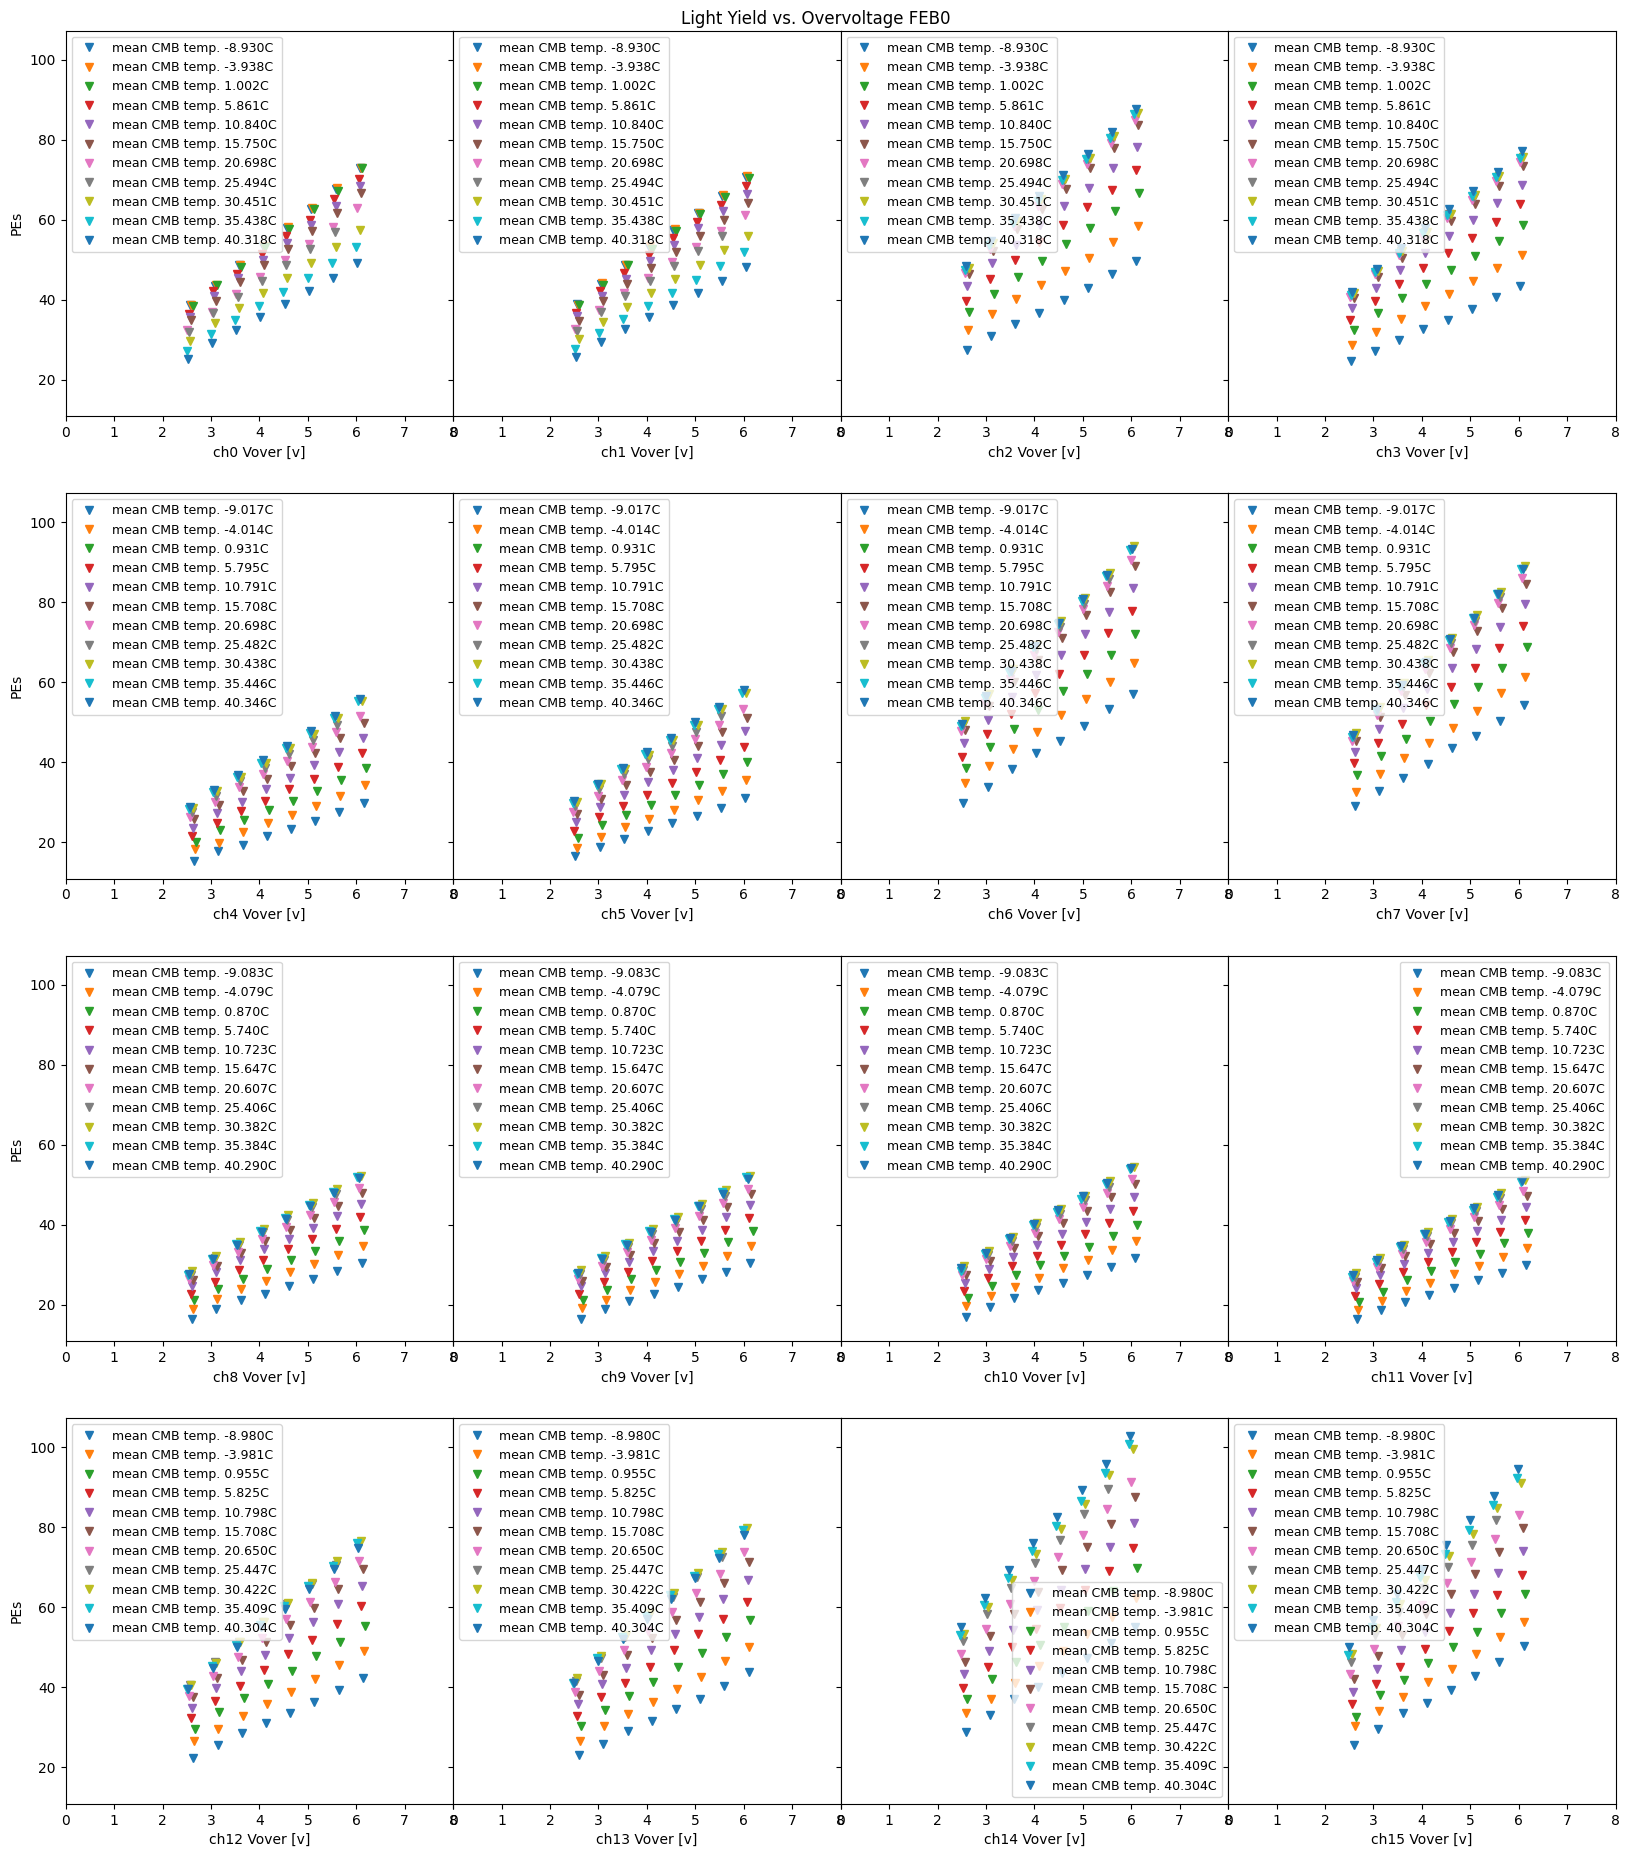

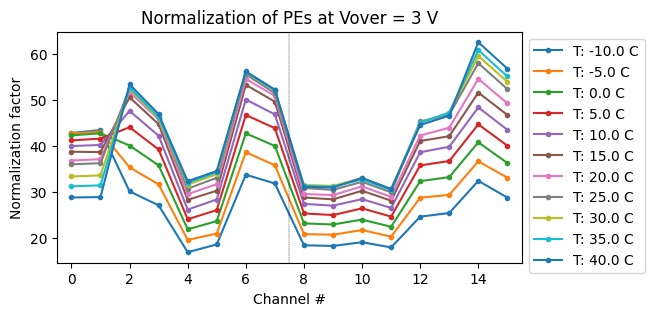

In [12]:
# grid of PEs vs Vover
normalization_Vover = 3
df_normalizationAt3VVover_scintbar = pd.DataFrame(columns=['ch', 'tempSetup', 'normalization'])

maintitle = 'Light Yield vs. Overvoltage'
fig, axs = plt.subplots(nrows = nr, ncols = nc, figsize = (5*nc, 5*nr/0.97), sharey = True)
plt.suptitle(maintitle+" FEB0")
plt.subplots_adjust(wspace=0)
fig.subplots_adjust(top=0.97)
ytitle = 'PEs'
xtitle = 'Vover [v]'
for index, ax in enumerate(axs.flatten()):
    chan = index
    ax.set_xlabel('ch%i '%chan+xtitle)
    if (index%4 == 0):
        ax.set_ylabel(ytitle)
    if chan in bad_channels:
        continue
    emptyFlag = True
    for tTempSetup in tempSetups:
        df_ = df_scan.query("ch==%i & tempSetup==%f"%(chan, tTempSetup)).reset_index()
        xx = df_['Vover'].astype(float)
        yy = df_['PEs'].astype(float)
        meanTemp = np.mean(df_['CMBtemp'].astype(float))
        mask = (yy>0)
        xx=xx[mask]
        yy=yy[mask]
        if yy.size==0:
            print("0PE channel: %d at set temp %.0f C"%(chan, tTempSetup))
            continue
        if True: #xx.size>3:
            emptyFlag = False
            tscatter = ax.plot(xx, yy, 'v', label='mean CMB temp. %.3fC'%(meanTemp))
            ax.set_xlim(0.,8.)
            # axs.set_ylim(20.,80.)
        if xx.size>3 and np.min(xx)<=3.5 and np.max(xx)>=2.5:
            popt, pcov = curve_fit(func_quad, xx.astype(float), yy.astype(float))
            tNormalization = popt[0]*3*3 + popt[1]*3 + popt[2]
            new_row = {'ch':chan, 
                       'tempSetup':tTempSetup, 
                       'normalization':tNormalization}
            df_normalizationAt3VVover_scintbar.loc[len(df_normalizationAt3VVover_scintbar)] = new_row 
        else:
            print("Cannot interpolate channel %d at set temp %.0f C"%(chan, tTempSetup))
            print(list(xx))
            new_row = {'ch':chan, 
                       'tempSetup':tTempSetup, 
                       'normalization':0.0}
            df_normalizationAt3VVover_scintbar.loc[len(df_normalizationAt3VVover_scintbar)] = new_row      
    if not emptyFlag:
        ax.legend(fontsize=9)
plt.show()

plt.figure(figsize = (6,3))
for temp in tempSetups:
    df_ = df_normalizationAt3VVover_scintbar.query('tempSetup==%f & normalization>0'%temp)
    plt.plot(df_['ch'], df_['normalization'],'.-',
                 label='T: %.1f C'%temp)
plt.title("Normalization of PEs at Vover = 3 V")
plt.xlabel("Channel #")
plt.ylabel("Normalization factor")
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
for iAFE in range(1,2):
    plt.axvline(x=8*iAFE-0.5, color='k', linestyle='-'if iAFE==0 else '--', linewidth=0.3)
plt.gca().set_xlim(-0.5, 15.5)
plt.show()

If LED has no temperature effect, PEs at 3V overvoltage should be the same for different temeperatures. The only remaining factor comes from LED + attenuation etc.

In [13]:
display(df_normalizationAt3VVover_scintbar)

ch  tempSetup  normalization
0     0      -10.0      42.763472
1     0       -5.0      42.656993
2     0        0.0      42.251699
3     0        5.0      41.142755
4     0       10.0      39.930248
..   ..        ...            ...
171  15       20.0      49.218260
172  15       25.0      52.319777
173  15       30.0      53.908448
174  15       35.0      55.070243
175  15       40.0      56.764867

[176 rows x 3 columns]

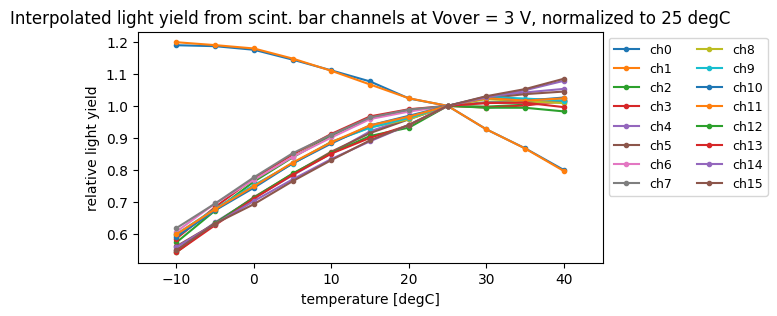

In [14]:
plt.figure(figsize = (6,3))
for ch in range(16):
    df_ = df_normalizationAt3VVover_scintbar.query("ch==%i"%ch).reset_index()
    normalization = df_.query("tempSetup==%f"%25.0).reset_index()['normalization'][0]
    plt.plot(df_['tempSetup'], df_['normalization']/normalization, '.-', label='ch%i'%ch)
plt.title("Interpolated light yield from scint. bar channels at Vover = 3 V, normalized to 25 degC")
plt.legend(fontsize=9, loc='upper left', bbox_to_anchor=(1.0, 1.0), ncol=2)
plt.xlabel('temperature [degC]')
plt.ylabel('relative light yield')
plt.gca().set_xlim(-15., 45.)
#plt.gca().set_ylim(0., 1.8)
plt.show()

I don't understand why ch 0/1 are different from the rest of the channels. Also, none of these look like the LED light yield-temp. curve. It means the light attenuation's dependence on the temperature is not negligible. This puts another question mark on the notion of "calibration using LED", as over time, different temperature may cause larger light yield change than say, aging.

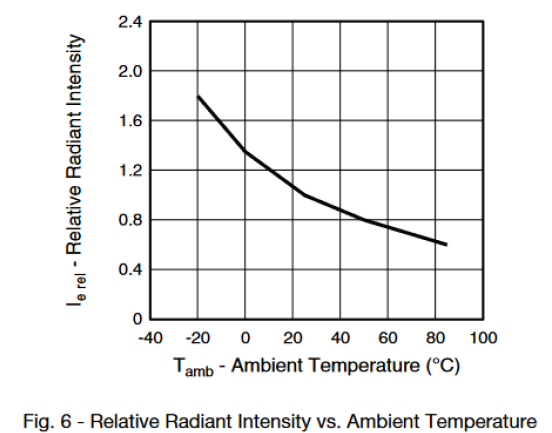